### Generating Shakespearean Text Using a Character RNN

1. Creating the Training Dataset

In [1]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"
filepath = tf.keras.utils.get_file("shakespeare.txt",shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 4s 4us/step


In [2]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


Next, we’ll use a tf.keras.layers.TextVectorization layer (introduced in Chapter 13) to
encode this text. We set split="character" to get character-level encoding rather than the default
word-level encoding, and we use standardize="lower" to convert the text to lowercase (which
will simplify the task):


In [3]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

Each character is now mapped to an integer, starting at 2. The TextVectorization layer reserved
the value 0 for padding tokens, and it reserved 1 for unknown characters. We won’t need either of
these tokens for now, so let’s subtract 2 from the character IDs and compute the number of distinct
characters and the total number of characters:

In [ ]:
encoded -= 2 
n_tokens = text_vec_layer.vocabulary_size() - 2
n_tokens # no. of distinct chars

39

In [ ]:
dataset_size = len(encoded)
dataset_size # total no. of chars

1115394

Next, just like we did in Chapter 15, we can turn this very long sequence into a dataset of windows
that we can then use to train a sequence-to-sequence RNN. The targets will be similar to the inputs,
but shifted by one time step into the “future”. For example, one sample in the dataset may be a
sequence of character IDs representing the text “to be or not to b” (without the final “e”), and the
corresponding target—a sequence of character IDs representing the text “o be or not to be” (with the
final “e”, but without the leading “t”). Let’s write a small utility function to convert a long sequence
of character IDs into a dataset of input/target window pairs:

In [6]:
def to_dataset(sequence, length,shuffle=False,seed=None,batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length+1))
    if shuffle:
        ds = ds.shuffle(buffer_size=100_000,seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:,:-1],window[:,1:])).prefetch(1)


Now we’re ready to create the training set, the validation set, and the test set. We will use roughly
90% of the text for training, 5% for validation, and 5% for testing

In [7]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000],length=length,
                       shuffle=True,seed=42)
valid_set = to_dataset(encoded[1_000_000:1_000_000],length=length)
test_set = to_dataset(encoded[1_060_000:],length=length)

>TIP
We set the window length to 100, but you can try tuning it: it’s easier and faster to train RNNs on shorter input sequences,
but the RNN will not be able to learn any pattern longer than length, so don’t make it too small.



### Building and Training the Char-RNN Model

Since our dataset is reasonably large, and modeling language is quite a difficult task, we need more
than a simple RNN with a few recurrent neurons. Let’s build and train a model with one GRU layer
composed of 128 units (you can try tweaking the number of layers and units later, if needed):

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens,output_dim=16),
    tf.keras.layers.GRU(128,return_sequences=True),
    tf.keras.layers.Dense(n_tokens,activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "nadam",
              metrics=["accuracy"])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model.keras",monitor="val_accuracy",
    save_best_only=True
)

history = model.fit(train_set,
                    validation_data=(valid_set),
                    epochs=10,
                    callbacks=[model_ckpt])

Epoch 1/10


   2526/Unknown 462s 159ms/step - accuracy: 0.3897 - loss: 2.1159

KeyboardInterrupt: 

This model does not handle text preprocessing, so let’s wrap it in a final model containing the
tf.keras.layers.TextVectorization layer as the first layer, plus a tf.keras.layers.Lambda
layer to subtract 2 from the character IDs since we’re not using the padding and unknown tokens for
now:

In [ ]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),
    model
])

In [ ]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0,-1]
y_pred = tf.argmax(y_proba) # choose the most probable character ID
text_vec_layer.get_vocabulary()[y_pred + 2] # e

Great, the model correctly predicted the next character. Now let’s use this model to pretend we’re
Shakespeare!

### Generating Fake Shakespearean Text

1. To generate new text using the char-RNN model, we could feed it some text, make the model predict
the most likely next letter, add it to the end of the text, then give the extended text to the model to
guess the next letter, and so on. This is called greedy decoding. But in practice this often leads to the
same words being repeated over and over again. Instead, we can sample the next character randomly,
with a probability equal to the estimated probability.

In [ ]:
log_probas = tf.math.log([[0.5,0.4,0.1]])
tf.random.set_seed(42)
tf.random.categorical(log_probas,num_samples=8) # draw 8 samples


To have more control over the diversity of the generated text, we can divide the logits by a number
called the temperature, which we can tweak as we wish. A temperature close to zero favors highprobability characters, while a high temperature gives all characters an equal probability. Lower
temperatures are typically preferred when generating fairly rigid and precise text, such as
mathematical equations, while higher temperatures are preferred when generating more diverse and
creative text.

In [ ]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

Next, we can write another small helper function that will repeatedly call next_char() to get the
next character and append it to the given text:

In [ ]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

We are now ready to generate some text! Let’s try with different temperature values:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
print(extend_text("To be or not to be", temperature=0.01))

In [ ]:
print(extend_text("To be or not to be", temperature=1))

In [ ]:
print(extend_text("To be or not to be", temperature=100))

* To generate more convincing text, a common
technique is to sample only from the top k characters, or only from the smallest set of top characters
whose total probability exceeds some threshold (this is called nucleus sampling).



### Stateful RNN:

1. Until now, we have only used stateless RNNs: at each training iteration the model starts with a
hidden state full of zeros, then it updates this state at each time step, and after the last time step, it
throws it away as it is not needed anymore. What if we instructed the RNN to preserve this final
state after processing a training batch and use it as the initial state for the next training batch? This
way the model could learn long-term patterns despite only backpropagating through short sequences.
This is called a stateful RNN. 

2.  note that a stateful RNN only makes sense if each input sequence in a batch starts exactly
where the corresponding sequence in the previous batch left off. So the first thing we need to do to
build a stateful RNN is to use sequential and nonoverlapping input sequences (rather than the
shuffled and overlapping sequences we used to train stateless RNNs). When creating the
tf.data.Dataset, we must therefore use shift=length (instead of shift=1) when calling the
window() method. Moreover, we must not call the shuffle() method.

3. Unfortunately, batching is much harder when preparing a dataset for a stateful RNN than it is for a
stateless RNN. Indeed, if we were to call batch(32), then 32 consecutive windows would be put in
the same batch, and the following batch would not continue each of these windows where it left off.
The first batch would contain windows 1 to 32 and the second batch would contain windows 33 to
64, so if you consider, say, the first window of each batch (i.e., windows 1 and 33), you can see that
they are not consecutive. The simplest solution to this problem is to just use a batch size of 1. The
following to_dataset_for_stateful_rnn() custom utility function uses this strategy to prepare a
dataset for a stateful RNN.



In [ ]:
def to_dataset_for_stateful_rnn(sequence,length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length+1,shift=length,drop_remainder=True)
    ds = ds.flat_map(lambda window: (window[:,:-1],window[:,1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000],length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_860_000],length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:],length)


Batching is harder, but it is not impossible. For example, we could chop Shakespeare’s text into 32
texts of equal length, create one dataset of consecutive input sequences for each of them, and finally
use tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows)) to create
proper consecutive batches, where the nth input sequence in a batch starts off exactly where the nth
input sequence ended in the previous batch.



Now, let’s create the stateful RNN. We need to set the stateful argument to True when creating
each recurrent layer, and because the stateful RNN needs to know the batch size (since it will
preserve a state for each input sequence in the batch). Therefore we must set the
batch_input_shape argument in the first layer. Note that we can leave the second dimension
unspecified, since the input sequences could have any length:

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
batch_input_shape=[1, None]),
tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
tf.keras.layers.Dense(n_tokens, activation="softmax")
])

At the end of each epoch, we need to reset the states before we go back to the beginning of the text.
For this, we can use a small custom Keras callback:


In [ ]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()


And now we can compile the model and train it using our callback

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
metrics=["accuracy"])


In [ ]:
history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
epochs=10, callbacks=[ResetStatesCallback(), model_ckpt])

### Sentiment Analysis

Let’s load the IMDb dataset using the TensorFlow Datasets library (introduced in Chapter 13). We’ll
use the first 90% of the training set for training, and the remaining 10% for validation:


In [ ]:
import tensorflow_datasets as tfds
raw_train_set, raw_valid_set, raw_test_set = tfds.load(
name="imdb_reviews",
split=["train[:90%]", "train[90%:]", "test"],
as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

Let’s inspect a few reviews:

In [ ]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8"))
    print("Label:", label.numpy())


* One of the techniques the authors evaluated is byte
pair encoding (BPE). BPE works by splitting the whole training set into individual characters
(including spaces), then repeatedly merging the most frequent adjacent pairs until the vocabulary
reaches the desired size.

* regularization technique called subword regularization, which improves accuracy and robustness by
introducing some randomness in tokenization during training: for example, “New England” may be
tokenized as “New” + “England”, or “New” + “Eng” + “land”, or simply “New England” (just one
token).



In [ ]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews,labels: reviews))

In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size,embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

history = model.fit(train_set,
                    validation_data=(valid_set),
                    epochs=3)

1. The reviews have
different lengths, so when the TextVectorization layer converts them to sequences of token IDs, it
pads the shorter sequences using the padding token (with ID 0) to make them as long as the longest
sequence in the batch. As a result, most sequences end with many padding tokens—often dozens or
even hundreds of them. Even though we’re using a GRU layer, which is much better than a
SimpleRNN layer, its short-term memory is still not great, so when it goes through many padding
tokens, it ends up forgetting what the review was about!

2. solutions:

* One solution is to feed the model with
batches of equal-length sentences (which also speeds up training).

* Masking: Another solution is to make the
RNN ignore the padding tokens. This can be done using masking.

3. Masking:

* Making the model ignore padding tokens is trivial using Keras: simply add mask_zero=True when
creating the Embedding layer. This means that padding tokens (whose ID is 0) will be ignored by all
downstream layers. That’s all! If you retrain the previous model for a few epochs, you will find that
the validation accuracy quickly reaches over 80%.

* The way this works is that the Embedding layer creates a mask tensor equal to
tf.math.not_equal(inputs, 0): it is a Boolean tensor with the same shape as the inputs, and it is
equal to False anywhere the token IDs are 0, or True otherwise. This mask tensor is then
automatically propagated by the model to the next layer. If that layer’s call() method has a mask
argument, then it automatically receives the mask. This allows the layer to ignore the appropriate
time steps. Each layer may handle the mask differently, but in general they simply ignore masked
time steps (i.e., time steps for which the mask is False). For example, when a recurrent layer
encounters a masked time step, it simply copies the output from the previous time step.

* Next, if the layer’s supports_masking attribute is True, then the mask is automatically propagated
to the next layer. It keeps propagating this way for as long as the layers have
supports_masking=True.


>TIP
Some layers need to update the mask before propagating it to the next layer: they do so by implementing the
compute_mask() method, which takes two arguments: the inputs and the previous mask. It then computes the updated
mask and returns it. The default implementation of compute_mask() just returns the previous mask unchanged.

* If the mask propagates all the way to the output, then it gets applied to the losses as well, so the
masked time steps will not contribute to the loss (their loss will be 0). This assumes that the model
outputs sequences, which is not the case in our sentiment analysis model.

* If you want to implement your own custom layer with masking support, you should add a mask
argument to the call() method, and obviously make the method use the mask. Additionally, if the
mask must be propagated to the next layers, then you should set self.supports_masking=True in
the constructor. If the mask must be updated before it is propagated, then you must implement the
compute_mask() method.

* If your model does not start with an Embedding layer, you may use the tf.keras.layers.Masking
layer instead: by default, it sets the mask to tf.math.reduce_any(tf.math.not_equal(X, 0),
axis=-1), meaning that time steps where the last dimension is full of zeros will be masked out in
subsequent layers.

* Using masking layers and automatic mask propagation works best for simple models. It will not
always work for more complex models, such as when you need to mix Conv1D layers with recurrent
layers. In such cases, you will need to explicitly compute the mask and pass it to the appropriate
layers, using either the functional API or the subclassing API. 

For example, the following model is
equivalent to the previous model, except it is built using the functional API and handles masking
manually. It also adds a bit of dropout since the previous model was overfitting slightly:


In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

One last approach to masking is to feed the model with ragged tensors. In practice, all you need to
do is to set ragged=True when creating the TextVectorization layer, so that the input sequences
are represented as ragged tensors:

In [ ]:
text_vec_layer_ragged = tf.keras.layers.TextVectorization(
max_tokens=vocab_size, ragged=True)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

Compare this ragged tensor representation with the regular tensor representation, which uses padding
tokens:

In [ ]:
text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

* Keras’s recurrent layers have built-in support for ragged tensors, so there’s nothing else you need to
do: just use this TextVectorization layer in your model. There’s no need to pass mask_zero=True
or handle masks explicitly—it’s all implemented for you.

* Whichever masking approach you prefer, after training this model for a few epochs, it will become
quite good at judging whether a review is positive or not. If you use the
tf.keras.callbacks.TensorBoard() callback, you can visualize the embeddings in TensorBoard
as they are being learned: it is fascinating to see words like “awesome” and “amazing” gradually
cluster on one side of the embedding space, while words like “awful” and “terrible” cluster on the
other side. Some words are not as positive as you might expect (at least with this model), such as the
word “good”, presumably because many negative reviews contain the phrase “not good”.



### Reusing Pretrained Embeddings and Language Models

1. Using pretrained word embeddings was popular for several years, but this approach has its limits. In
particular, a word has a single representation, no matter the context. For example, the word “right” is
encoded the same way in “left and right” and “right and wrong”, even though it means two very
different things.

2. Embeddings from Language Models (ELMo): these are contextualized word embeddings learned
from the internal states of a deep bidirectional language model. Instead of just using pretrained
embeddings in your model, you reuse part of a pretrained language model.

For example, let’s build a classifier based on the Universal Sentence Encode


In [ ]:
import os
import tensorflow_hub as hub
os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"

model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
trainable=True, dtype=tf.string, input_shape=[]),
tf.keras.layers.Dense(64, activation="relu"),
tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=10)

### An Encoder–Decoder Network for Neural Machine Translation

let's Begin with a simple NMT model: English sentences to spanish.

1. the architecture is as follows: English sentences are fed as inputs to the encoder, and the
decoder outputs the Spanish translations. Note that the Spanish translations are also used as inputs to
the decoder during training, but shifted back by one step. In other words, during training the decoder
is given as input the word that it should have output at the previous step, regardless of what it
actually output. This is called teacher forcing—a technique that significantly speeds up training and
improves the model’s performance. For the very first word, the decoder is given the start-ofsequence (SOS) token, and the decoder is expected to end the sentence with an end-of-sequence
(EOS) token.

2. Each word is initially represented by its ID (e.g., 854 for the word “soccer”). Next, an Embedding
layer returns the word embedding. These word embeddings are then fed to the encoder and the
decoder.

3. At each step, the decoder outputs a score for each word in the output vocabulary (i.e., Spanish), then
the softmax activation function turns these scores into probabilities. For example, at the first step the
word “Me” may have a probability of 7%, “Yo” may have a probability of 1%, and so on. The word
with the highest probability is output.

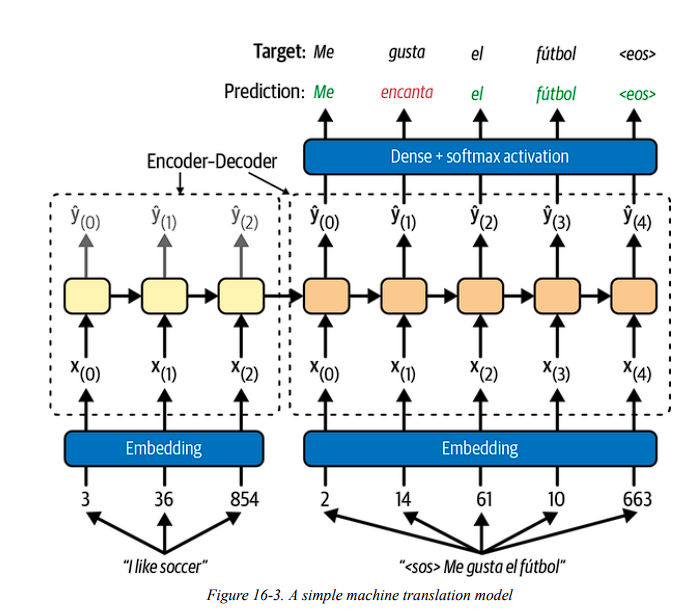


>Note that at inference time (after training), you will not have the target sentence to feed to the
decoder. Instead, you need to feed it the word that it has just output at the previous step, as shown in
Figure 16-4 (this will require an embedding lookup that is not shown in the diagram).

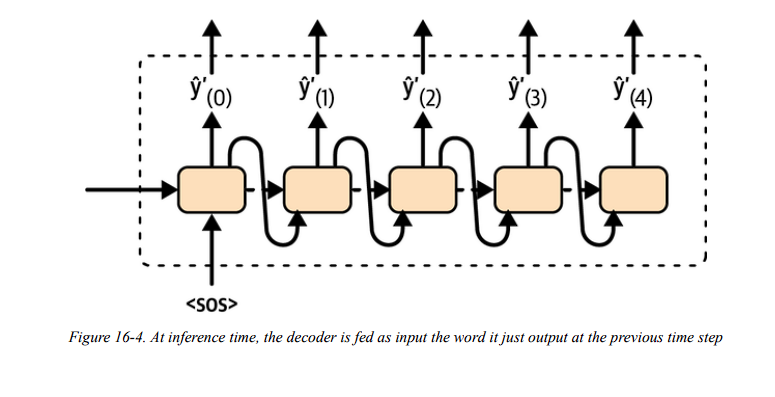



Let’s build and train this model! First, we need to download a dataset of English/Spanish sentence
pairs

In [ ]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path  = tf.keras.utils.get_file("spa-eng.zip",origin=url,
                                cache_dir="datasets",
                                extract=True)
from pathlib import Path

text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

Each line contains an English sentence and the corresponding Spanish translation, separated by a tab.
We’ll start by removing the Spanish characters “¡” and “¿”, which the TextVectorization layer
doesn’t handle, then we will parse the sentence pairs and shuffle them. Finally, we will split them
into two separate lists, one per language:


In [ ]:
import numpy as np

text = text.replace("i","").replace("¿","")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)

Let’s take a look at the first three sentence pairs:

In [ ]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

Next, let’s create two TextVectorization layers—one per language—and adapt them to the text:


In [ ]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

There are a few things to note here:

* We limit the vocabulary size to 1,000, which is quite small. That’s because the training set is not
very large, and because using a small value will speed up training. State-of-the-art translation
models typically use a much larger vocabulary (e.g., 30,000), a much larger training set
(gigabytes), and a much larger model (hundreds or even thousands of megabytes). For example,
check out the Opus-MT models by the University of Helsinki, or the M2M-100 model by
Facebook.

* Since all sentences in the dataset have a maximum of 50 words, we set
output_sequence_length to 50: this way the input sequences will automatically be padded
with zeros until they are all 50 tokens long. If there was any sentence longer than 50 tokens in
the training set, it would be cropped to 50 tokens.

* For the Spanish text, we add “startofseq” and “endofseq” to each sentence when adapting the
TextVectorization layer: we will use these words as SOS and EOS tokens. You could use
any other words, as long as they are not actual Spanish words.

Let’s inspect the first 10 tokens in both vocabularies. They start with the padding token, the
unknown token, the SOS and EOS tokens (only in the Spanish vocabulary), then the actual words,
sorted by decreasing frequency

In [ ]:
text_vec_layer_en.get_vocabulary()[:10]

In [ ]:
text_vec_layer_es.get_vocabulary()[:10]


Next, let’s create the training set and the validation set (you could also create a test set if you needed
it). We will use the first 100,000 sentence pairs for training, and the rest for validation. The decoder’s
inputs are the Spanish sentences plus an SOS token prefix. The targets are the Spanish sentences plus
an EOS suffix

In [ ]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

OK, we’re now ready to build our translation model. We will use the functional API for that since
the model is not sequential. It requires two text inputs—one for the encoder and one for the decoder
—so let’s start with that:


In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

Next, we need to encode these sentences using the TextVectorization layers we prepared earlier,
followed by an Embedding layer for each language, with mask_zero=True to ensure masking is
handled automatically. The embedding size is a hyperparameter you can tune, as alway

In [ ]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

Now let’s create the encoder and pass it the embedded inputs

In [ ]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

To keep things simple, we just used a single LSTM layer, but you could stack several of them. We also
set return_state=True to get a reference to the layer’s final state. Since we’re using an LSTM layer,
there are actually two states: the short-term state and the long-term state. The layer returns these
states separately, which is why we had to write *encoder_state to group both states in a list.
Now we can use this (double) state as the initial state of the decoder:

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

Next, we can pass the decoder’s outputs through a Dense layer with the softmax activation function
to get the word probabilities for each step:

In [ ]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)


### OPTIMIZING THE OUTPUT LAYER

* When the output vocabulary is large, outputting a probability for each and every possible word
can be quite slow. If the target vocabulary contained, say, 50,000 Spanish words instead of 1,000,
then the decoder would output 50,000-dimensional vectors, and computing the softmax function
over such a large vector would be very computationally intensive. To avoid this, one solution is
to look only at the logits output by the model for the correct word and for a random sample of
incorrect words, then compute an approximation of the loss based only on these logits. This
sampled softmax technique was introduced in 2015 by Sébastien Jean et al. In TensorFlow you
can use the tf.nn.sampled_softmax_loss() function for this during training and use the
normal softmax function at inference time (sampled softmax cannot be used at inference time
because it requires knowing the target).

* Another thing you can do to speed up training—which is compatible with sampled softmax—is
to tie the weights of the output layer to the transpose of the decoder’s embedding matrix (you
will see how to tie weights in Chapter 17). This significantly reduces the number of model
parameters, which speeds up training and may sometimes improve the model’s accuracy as well,
especially if you don’t have a lot of training data. The embedding matrix is equivalent to one-hot
encoding followed by a linear layer with no bias term and no activation function that maps the
one-hot vectors to the embedding space. The output layer does the reverse. So, if the model can
find an embedding matrix whose transpose is close to its inverse (such a matrix is called an
orthogonal matrix), then there’s no need to learn a separate set of weights for the output layer.


And that’s it! We just need to create the Keras Model, compile it, and train i

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
validation_data=((X_valid, X_valid_dec), Y_valid))

After training, we can use the model to translate new English sentences to Spanish. But it’s not as
simple as calling model.predict(), because the decoder expects as input the word that was
predicted at the previous time step. One way to do this is to write a custom memory cell that keeps
track of the previous output and feeds it to the encoder at the next time step.

 However, to keep things
simple, we can just call the model multiple times, predicting one extra word at each round. Let’s
write a little utility function for that:

In [ ]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en]) # encoder input
        X_dec = np.array(["startofseq " + translation]) # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx] # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()


The function simply keeps predicting one word at a time, gradually completing the translation, and it
stops once it reaches the EOS token. Let’s give it a try!

In [ ]:
translate("I like soccer")

Hurray, it works! Well, at least it does with very short sentences. If you try playing with this model
for a while, you will find that it’s not bilingual yet, and in particular it really struggles with longer
sentences. For example:


In [ ]:
translate("I like soccer and also going to the beach")

### Bidirectional RNNs

1. At each time step, a regular recurrent layer only looks at past and present inputs before generating its
output. In other words, it is causal, meaning it cannot look into the future. This type of RNN makes
sense when forecasting time series, or in the decoder of a sequence-to-sequence (seq2seq) model.
But for tasks like text classification, or in the encoder of a seq2seq model, it is often preferable to
look ahead at the next words before encoding a given word.

2. For example, consider the phrases “the right arm”, “the right person”, and “the right to criticize”: to
properly encode the word “right”, you need to look ahead. One solution is to run two recurrent layers
on the same inputs, one reading the words from left to right and the other reading them from right to
left, then combine their outputs at each time step, typically by concatenating them. This is what a
bidirectional recurrent layer does. (see Figure 16-5)

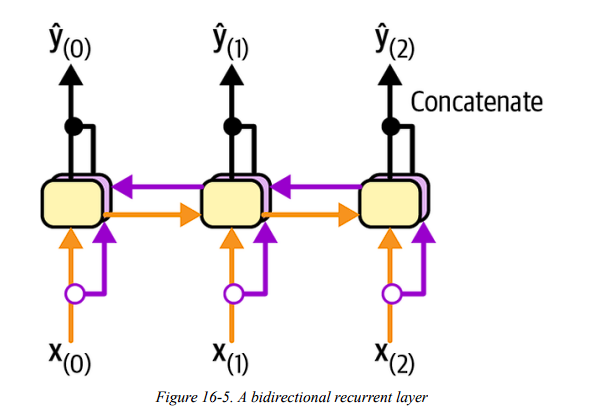

To implement a bidirectional recurrent layer in Keras, just wrap a recurrent layer in a
tf.keras.layers.Bidirectional layer. For example, the following Bidirectional layer could
be used as the encoder in our translation model:

In [ ]:
encoder = tf.keras.layers.Bidirectional(
tf.keras.layers.LSTM(256, return_state=True))

>NOTE
The Bidirectional layer will create a clone of the GRU layer (but in the reverse direction), and it will run both and
concatenate their outputs. So although the GRU layer has 10 units, the Bidirectional layer will output 20 values per time
step.

3. There’s just one problem. This layer will now return four states instead of two: the final short-term
and long-term states of the forward LSTM layer, and the final short-term and long-term states of the
backward LSTM layer. We cannot use this quadruple state directly as the initial state of the decoder’s
LSTM layer, since it expects just two states (short-term and long-term). We cannot make the decoder
bidirectional, since it must remain causal: otherwise it would cheat during training and it would not
work. Instead, we can concatenate the two short-term states, and also concatenate the two long-term
states:




In [ ]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1), # short-term (0 & 2)
tf.concat(encoder_state[1::2], axis=-1)] # long-term (1 & 3)

### Beam Search

1. Suppose you have trained an encoder–decoder model, and you use it to translate the sentence “I like
soccer” to Spanish. You are hoping that it will output the proper translation “me gusta el fútbol”, but
unfortunately it outputs “me gustan los jugadores”, which means “I like the players”. Looking at the
training set, you notice many sentences such as “I like cars”, which translates to “me gustan los
autos”, so it wasn’t absurd for the model to output “me gustan los” after seeing “I like”.
Unfortunately, in this case it was a mistake since “soccer” is singular. The model could not go back
and fix it, so it tried to complete the sentence as best it could, in this case using the word
“jugadores”. How can we give the model a chance to go back and fix mistakes it made earlier?

2. One
of the most common solutions is beam search: it keeps track of a short list of the k most promising
sentences (say, the top three), and at each decoder step it tries to extend them by one word, keeping
only the k most likely sentences. The parameter k is called the beam width.

3. For example, suppose you use the model to translate the sentence “I like soccer” using beam search
with a beam width of 3 (see Figure 16-6). At the first decoder step, the model will output an
estimated probability for each possible first word in the translated sentence. Suppose the top three
words are “me” (75% estimated probability), “a” (3%), and “como” (1%). That’s our short list so far.
Next, we use the model to find the next word for each sentence. For the first sentence (“me”),
perhaps the model outputs a probability of 36% for the word “gustan”, 32% for the word “gusta”,
16% for the word “encanta”, and so on. Note that these are actually conditional probabilities, given
that the sentence starts with “me”. For the second sentence (“a”), the model might output a
conditional probability of 50% for the word “mi”, and so on. Assuming the vocabulary has 1,000
words, we will end up with 1,000 probabilities per sentence.

4. Next, we compute the probabilities of each of the 3,000 two-word sentences we considered (3 ×
1,000). We do this by multiplying the estimated conditional probability of each word by the
estimated probability of the sentence it completes. For example, the estimated probability of the
sentence “me” was 75%, while the estimated conditional probability of the word “gustan” (given that
the first word is “me”) was 36%, so the estimated probability of the sentence “me gustan” is 75% ×
36% = 27%. After computing the probabilities of all 3,000 two-word sentences, we keep only the top
3 . In this example they all start with the word “me”: “me gustan” (27%), “me gusta” (24%), and “me
encanta” (12%). Right now, the sentence “me gustan” is winning, but “me gusta” has not been
eliminated.

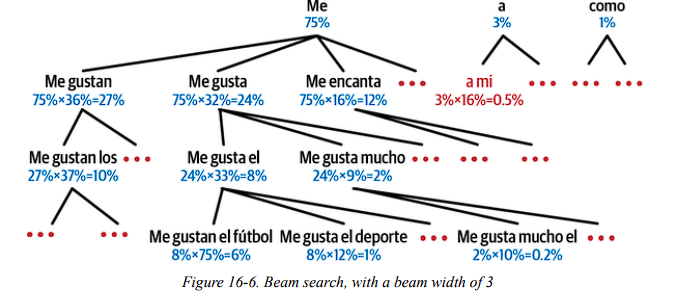

5. Then we repeat the same process: we use the model to predict the next word in each of these three
sentences, and we compute the probabilities of all 3,000 three-word sentences we considered.
Perhaps the top three are now “me gustan los” (10%), “me gusta el” (8%), and “me gusta mucho”
(2%). At the next step we may get “me gusta el fútbol” (6%), “me gusta mucho el” (1%), and “me
gusta el deporte” (0.2%). Notice that “me gustan” was eliminated, and the correct translation is now
ahead. We boosted our encoder–decoder model’s performance without any extra training, simply by
using it more wisely.

6. Unfortunately, this
model will be really bad at translating long sentences. Once again, the problem comes from the
limited short-term memory of RNNs. Attention mechanisms are the game-changing innovation that
addressed this problem.



###  Attention Mechanisms

1. Consider the path from the word “soccer” to its translation “fútbol” back in Figure 16-3: it is quite
long! This means that a representation of this word (along with all the other words) needs to be
carried over many steps before it is actually used. Can’t we make this path shorter?

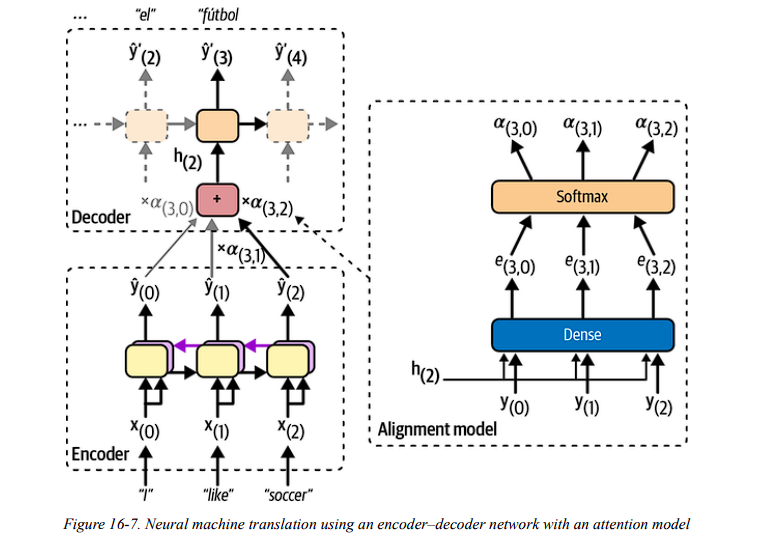

2. authors
introduced a technique that allowed the decoder to focus on the appropriate words (as encoded by
the encoder) at each time step. For example, at the time step where the decoder needs to output the
word “fútbol”, it will focus its attention on the word “soccer”. This means that the path from an input
word to its translation is now much shorter, so the short-term memory limitations of RNNs have
much less impact. Attention mechanisms revolutionized neural machine translation (and deep
learning in general), allowing a significant improvement in the state of the art, especially for long
sentences (e.g., over 30 words).

>NOTE
The most common metric used in NMT is the bilingual evaluation understudy (BLEU) score, which compares each
translation produced by the model with several good translations produced by humans: it counts the number of n-grams
(sequences of n words) that appear in any of the target translations and adjusts the score to take into account the
frequency of the produced n-grams in the target translations.

3. Figure 16-7 shows our encoder–decoder model with an added attention mechanism. On the left, you
have the encoder and the decoder. Instead of just sending the encoder’s final hidden state to the
decoder, as well as the previous target word at each step (which is still done, although it is not shown
in the figure), we now send all of the encoder’s outputs to the decoder as well. Since the decoder
cannot deal with all these encoder outputs at once, they need to be aggregated: at each time step, the
decoder’s memory cell computes a weighted sum of all the encoder outputs.

4. This determines which
words it will focus on at this step. The weight α is the weight of the ith encoder output at the t^th
decoder time step. For example, if the weight α_(3,2) is much larger than the weights α_(3,0) and α_(3,1) ,
then the decoder will pay much more attention to the encoder’s output for word #2 (“soccer”) than to
the other two outputs, at least at this time step. The rest of the decoder works just like earlier: at each
time step the memory cell receives the inputs we just discussed, plus the hidden state from the
previous time step, and finally (although it is not represented in the diagram) it receives the target
word from the previous time step (or at inference time, the output from the previous time step).

5. But where do these α weights come from? Well, they are generated by a small neural network
called an alignment model (or an attention layer), which is trained jointly with the rest of the
encoder–decoder model. This alignment model is illustrated on the righthand side of Figure 16-7. It
starts with a Dense layer composed of a single neuron that processes each of the encoder’s outputs,
along with the decoder’s previous hidden state (e.g., h_2 ). This layer outputs a score (or energy) for
each encoder output (e.g., e_(3,2) ): this score measures how well each output is aligned with the
decoder’s previous hidden state. For example, in Figure 16-7, the model has already output “me
gusta el” (meaning “I like”), so it’s now expecting a noun: the word “soccer” is the one that best
aligns with the current state, so it gets a high score. Finally, all the scores go through a softmax layer
to get a final weight for each encoder output (e.g., α_(3,2) ). All the weights for a given decoder time
step add up to 1. This particular attention mechanism is called Bahdanau attention (named after the
2014 paper’s first author). Since it concatenates the encoder output with the decoder’s previous
hidden state, it is sometimes called concatenative attention (or additive attention). 

> NOTE
If the input sentence is n words long, and assuming the output sentence is about as long, then this model will need to
compute about n weights. Fortunately, this quadratic computational complexity is still tractable because even long
sentences don’t have thousands of words.

6. Another common attention mechanism, known as Luong attention or multiplicative attention. 

* the goal of the alignment
model is to measure the similarity between one of the encoder’s outputs and the decoder’s previous
hidden state, the authors proposed to simply compute the dot product (see Chapter 4) of these two
vectors, as this is often a fairly good similarity measure, and modern hardware can compute it very
efficiently. For this to be possible, both vectors must have the same dimensionality. The dot product
gives a score, and all the scores (at a given decoder time step) go through a softmax layer to give the
final weights, just like in Bahdanau attention.

* Another simplification Luong et al. proposed was to
use the decoder’s hidden state at the current time step rather than at the previous time step (i.e., h_t
rather than h_(t-1) ), then to use the output of the attention mechanism (noted h˜(t)) directly to compute
the decoder’s predictions, rather than using it to compute the decoder’s current hidden state. The
researchers also proposed a variant of the dot product mechanism where the encoder outputs first go
through a fully connected layer (without a bias term) before the dot products are computed. This is
called the “general” dot product approach. The researchers compared both dot product approaches
with the concatenative attention mechanism (adding a rescaling parameter vector v), and they
observed that the dot product variants performed better than concatenative attention. For this reason,
concatenative attention is much less used now.

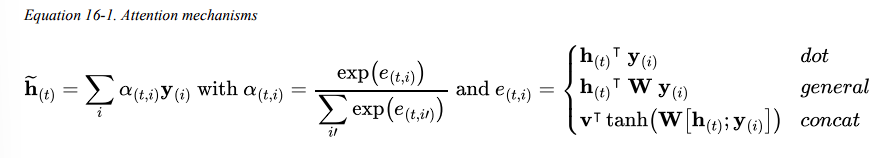




Keras provides a tf.keras.layers.Attention layer for Luong attention, and an
AdditiveAttention layer for Bahdanau attention. Let’s add Luong attention to our encoder–
decoder model. Since we will need to pass all the encoder’s outputs to the Attention layer, we first
need to set return_sequences=True when creating the encoder:


In [ ]:
encoder = tf.keras.layers.Bidirectional(
tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

Next, we need to create the attention layer and pass it the decoder’s states and the encoder’s outputs.
However, to access the decoder’s states at each step we would need to write a custom memory cell.


In [ ]:
"""For simplicity, let’s use the decoder’s outputs instead of its states: in practice this works well too, and
it’s much easier to code. Then we just pass the attention layer’s outputs directly to the output layer,
as suggested in the Luong attention paper:"""

attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

And that’s it! If you train this model, you will find that it now handles much longer sentences. For
example:

In [ ]:
translate("I like soccer and also going to the beach")

### Attention Is All You Need: The Original Transformer Architecture

1. They created an architecture called the transformer, which significantly improved the
state-of-the-art in NMT without using any recurrent or convolutional layers, just attention
mechanisms (plus embedding layers, dense layers, normalization layers, and a few other bits and
pieces). Because the model is not recurrent, it doesn’t suffer as much from the vanishing or
exploding gradients problems as RNNs, it can be trained in fewer steps, it’s easier to parallelize
across multiple GPUs, and it can better capture long-range patterns than RNNs.

2. the left part of Figure 16-8 is the encoder, and the right part is the decoder. Each embedding
layer outputs a 3D tensor of shape [batch size, sequence length, embedding size]. After that, the
tensors are gradually transformed as they flow through the transformer, but their shape remains the
same.

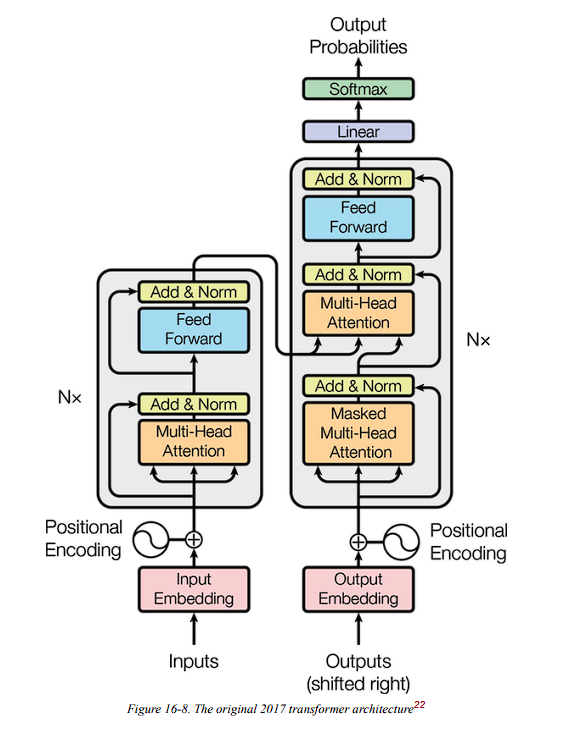


* First, notice that both the encoder and the decoder contain modules that are stacked N times. In
the paper, N = 6. The final outputs of the whole encoder stack are fed to the decoder at each of
these N levels.

* Zooming in, you can see that you are already familiar with most components: there are two
embedding layers; several skip connections, each of them followed by a layer normalization
layer; several feedforward modules that are composed of two dense layers each (the first one
using the ReLU activation function, the second with no activation function); and finally the
output layer is a dense layer using the softmax activation function. You can also sprinkle a bit of
dropout after the attention layers and the feedforward modules, if needed. Since all of these
layers are time-distributed, each word is treated independently from all the others. But how can
we translate a sentence by looking at the words completely separately? Well, we can’t, so that’s
where the new components come in:

1. The encoder’s multi-head attention layer updates each word representation by attending to
(i.e., paying attention to) all other words in the same sentence. That’s where the vague
representation of the word “like” becomes a richer and more accurate representation,
capturing its precise meaning in the given sentence. We will discuss exactly how this
works shortly.

2. The decoder’s masked multi-head attention layer does the same thing, but when it
processes a word, it doesn’t attend to words located after it: it’s a causal layer. For
example, when it processes the word “gusta”, it only attends to the words “<SOS> me
gusta”, and it ignores the words “el fútbol” (or else that would be cheating).

3. The decoder’s upper multi-head attention layer is where the decoder pays attention to the
words in the English sentence. This is called cross-attention, not self-attention in this case.
For example, the decoder will probably pay close attention to the word “soccer” when it
processes the word “el” and transforms its representation into a representation of the word
“fútbol”.

4. The positional encodings are dense vectors (much like word embeddings) that represent
the position of each word in the sentence. The n positional encoding is added to the word
embedding of the n word in each sentence. This is needed because all layers in the
transformer architecture ignore word positions: without positional encodings, you could
shuffle the input sequences, and it would just shuffle the output sequences in the same way.
Obviously, the order of words matters, which is why we need to give positional
information to the transformer somehow: adding positional encodings to the word
representations is a good way to achieve this.

>NOTE
The first two arrows going into each multi-head attention layer in Figure 16-8 represent the keys and values, and the third
arrow represents the queries. In the self-attention layers, all three are equal to the word representations output by the
previous layer, while in the decoder’s upper attention layer, the keys and values are equal to the encoder’s final word
representations, and the queries are equal to the word representations output by the previous layer.






### Positional encodings

1. A positional encoding is a dense vector that encodes the position of a word within a sentence: the ith
positional encoding is added to the word embedding of the ith word in the sentence. The easiest way
to implement this is to use an Embedding layer and make it encode all the positions from 0 to the
maximum sequence length in the batch, then add the result to the word embeddings. The rules of
broadcasting will ensure that the positional encodings get applied to every input sequence.

For
example, here is how to add positional encodings to the encoder and decoder inputs:

In [5]:
max_length = 50
embed_size = 128
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))


NameError: name 'encoder_embeddings' is not defined

>Note that this implementation assumes that the embeddings are represented as regular tensors, not
ragged tensors. The encoder and the decoder share the same Embedding layer for the positional
encodings, since they have the same embedding size (this is often the case).

2. Instead of using trainable positional encodings, the authors of the transformer paper chose to use
fixed positional encodings, based on the sine and cosine functions at different frequencies. The
positional encoding matrix P is defined in Equation 16-2 and represented at the top of Figure 16-9
(transposed), where P_(p,i) is the ith component of the encoding for the word located at the pth position
in the sentence.

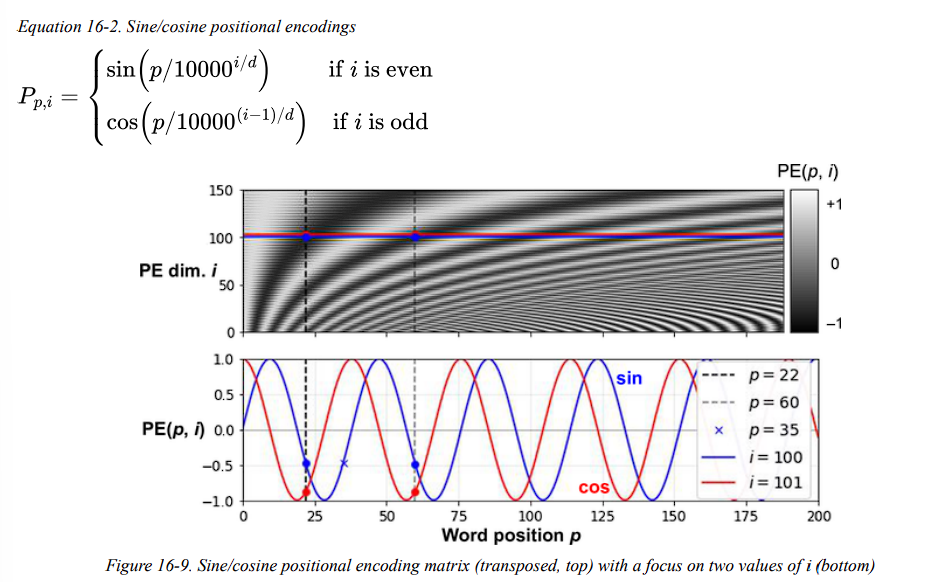

3. This solution can give the same performance as trainable positional encodings, and it can extend to
arbitrarily long sentences without adding any parameters to the model (however, when there is a
large amount of pretraining data, trainable positional encodings are usually favored).

4. After these
positional encodings are added to the word embeddings, the rest of the model has access to the
absolute position of each word in the sentence because there is a unique positional encoding for each
position (e.g., the positional encoding for the word located at the 22nd position in a sentence is
represented by the vertical dashed line at the top left of Figure 16-9, and you can see that it is unique
to that position). Moreover, the choice of oscillating functions (sine and cosine) makes it possible for
the model to learn relative positions as well. For example, words located 38 words apart (e.g., at
positions p = 22 and p = 60) always have the same positional encoding values in the encoding
dimensions i = 100 and i = 101, as you can see in Figure 16-9. This explains why we need both the
sine and the cosine for each frequency: if we only used the sine (the blue wave at i = 100), the model
would not be able to distinguish positions p = 22 and p = 35 (marked by a cross).

There is no PositionalEncoding layer in TensorFlow, but it is not too hard to create one

In [3]:
"""supports_masking=True to propagate the input’s automatic mask to the
next layer:"""
import tensorflow as tf
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self,max_length,embed_size,dtype=tf.float32,**kwargs):
        super().__init__(dtype=dtype,**kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1,max_length,embed_size))
        pos_emb[0,:,::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0,:,1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encoding = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self,inputs):
        batch_max_length  = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:,:batch_max_length]

Let’s use this layer to add the positional encoding to the encoder’s inputs:

In [4]:
pos_embed_layer = PositionalEncoding(max_length,embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

NameError: name 'max_length' is not defined

### Multi-head attention

1. To understand how a multi-head attention layer works, we must first understand the scaled dotproduct attention layer, which it is based on. Its equation is shown in Equation 16-3, in a vectorized
form.

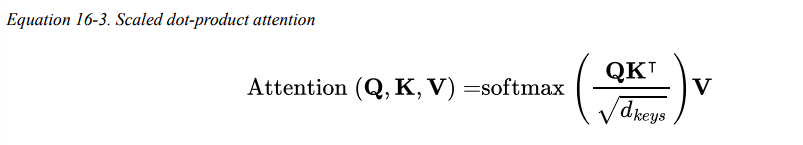

In This Equation:

* q is a matrix containing one row per query. Its shape is [n_queries, d_keys], where n_queries is the number of queries and d_keys is the number of dims of each query and each key.

* K is a matrix containing one row per key. Its shape is [n_keys , d_keys ], where n_keys is the number of
keys and values.

* V is a matrix containing one row per value. Its shape is [n_keys, d_keys ], where d_values is the
number of dimensions of each value.

* The shape of Q K^T is [n_queries , n_keys ]: it contains one similarity score for each query/key pair. To
prevent this matrix from being huge, the input sequences must not be too long (we will discuss
how to overcome this limitation later in this chapter). The output of the softmax function has
the same shape, but all rows sum up to 1. The final output has a shape of [n_queries , d_values ]: there
is one row per query, where each row represents the query result (a weighted sum of the
values).

* The scaling factor 1 / (√dkeys) scales down the similarity scores to avoid saturating the softmax
function, which would lead to tiny gradients.

* It is possible to mask out some key/value pairs by adding a very large negative value to the
corresponding similarity scores, just before computing the softmax. This is useful in the masked
multi-head attention layer.

2. If you set use_scale=True when creating a tf.keras.layers.Attention layer, then it will create
an additional parameter that lets the layer learn how to properly downscale the similarity scores. The
scaled dot-product attention used in the transformer model is almost the same, except it always
scales the similarity scores by the same factor, 1 / (√dkeys).

>Note that the Attention layer’s inputs are just like Q, K, and V, except with an extra batch
dimension (the first dimension). Internally, the layer computes all the attention scores for all
sentences in the batch with just one call to tf.matmul(queries, keys): this makes it extremely
efficient.

* Indeed, in TensorFlow, if A and B are tensors with more than two dimensions—say, of
shape [2, 3, 4, 5] and [2, 3, 5, 6], respectively—then tf.matmul(A, B) will treat these tensors as
2 × 3 arrays where each cell contains a matrix, and it will multiply the corresponding matrices: the
matrix at the ith row and jth column in A will be multiplied by the matrix at the ith row and jth column
in B. Since the product of a 4 × 5 matrix with a 5 × 6 matrix is a 4 × 6 matrix, tf.matmul(A, B) will
return an array of shape [2, 3, 4, 6].

Now we’re ready to look at the multi-head attention layer. Its architecture is shown in Figure 16-10.

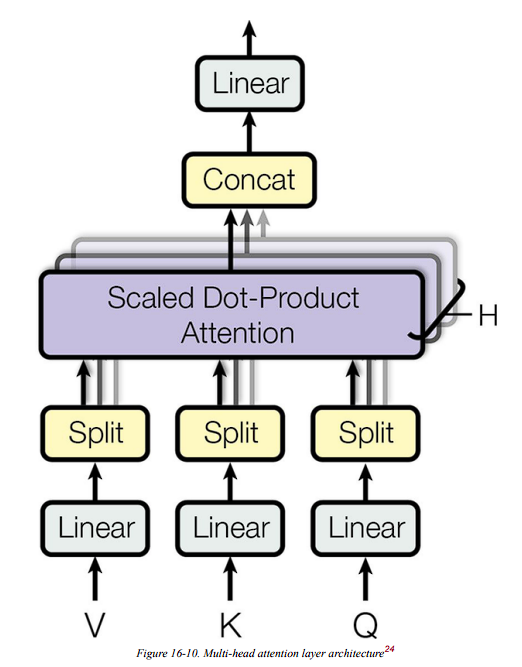

3. What is the intuition behind this architecture?

* consider once again the word “like” in
the sentence “I like soccer”. The encoder was smart enough to encode the fact that it is a verb. But
the word representation also includes its position in the text, thanks to the positional encodings, and
it probably includes many other features that are useful for its translation, such as the fact that it is in
the present tense. In short, the word representation encodes many different characteristics of the
word. If we just used a single scaled dot-product attention layer, we would only be able to query all
of these characteristics in one shot.

* Then the scaled dot-product attention layers implement the lookup phase,
and finally we concatenate all the results and project them back to the original space.

Keras includes a tf.keras.layers.MultiHeadAttention layer, so we now have everything we
need to build the rest of the transformer

 Let’s start with the full encoder, which is exactly like in
Figure 16-8, except we use a stack of two blocks (N = 2) instead of six, since we don’t have a huge
training set, and we add a bit of dropout as well:


In [6]:
N = 2 #instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128 #for the first dense layer in each feedforward block
encoder_pad_mask = tf.math.not_equal(encoder_input_ids,0)[:,tf.newaxis]
Z = encoder_in

for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim = embed_size,
        dropout_rate=dropout_rate
    ) 
    Z = attn_layer(Z,value=Z,attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()[Z,skip])
    skip = Z
    Z = tf.keras.layers.Dense(n_units,activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z,skip]))
    

NameError: name 'encoder_input_ids' is not defined

4. This code should be mostly straightforward, except for one thing: masking. As of the time of writing,
the MultiHeadAttention layer does not support automatic masking, so we must handle it
manually. How can we do that?

* The MultiHeadAttention layer accepts an attention_mask argument, which is a Boolean tensor
of shape [batch size, max query length, max value length]: for every token in every query sequence,
this mask indicates which tokens in the corresponding value sequence should be attended to. We
want to tell the MultiHeadAttention layer to ignore all the padding tokens in the values. So, we
first compute the padding mask using tf.math.not_equal(encoder_input_ids, 0). This returns
a Boolean tensor of shape [batch size, max sequence length]. We then insert a second axis using [:,
tf.newaxis], to get a mask of shape [batch size, 1, max sequence length]. This allows us to use this
mask as the attention_mask when calling the MultiHeadAttention layer: thanks to broadcasting,
the same mask will be used for all tokens in each query. This way, the padding tokens in the values
will be ignored correctly.

* However, the layer will compute outputs for every single query token, including the padding tokens.
We need to mask the outputs that correspond to these padding tokens. Recall that we used
mask_zero in the Embedding layers, and we set supports_masking to True in the
PositionalEncoding layer, so the automatic mask was propagated all the way to the
MultiHeadAttention layer’s inputs (encoder_in). We can use this to our advantage in the skip
connection: indeed, the Add layer supports automatic masking, so when we add Z and skip (which is
initially equal to encoder_in), the outputs get automatically masked correctly. Yikes! Masking
required much more explanation than code.

Now on to the decoder! Once again, masking is going to be the only tricky part, so let’s start with
that. The first multi-head attention layer is a self-attention layer, like in the encoder, but it is a
masked multi-head attention layer, meaning it is causal: it should ignore all tokens in the future. So,
we need two masks: a padding mask and a causal mask

In [ ]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids,0)[:,tf.newaxis]
causal_mask = tf.linalg.band_part( # creates a lower triangular matrix
    tf.ones((batch_max_len_dec, batch_max_len_dec),tf.bool),-1,0
)

Let’s now build the decoder:

In [ ]:
encoder_outputs = Z # let's sabe the encoder's final outputs
Z = decoder_in # the decoder starts with its own inputs
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

For the first attention layer, we use causal_mask & decoder_pad_mask to mask both the padding
tokens and future tokens. The causal mask only has two dimensions: it’s missing the batch
dimension, but that’s okay since broadcasting ensures that it gets copied across all the instances in
the batch.

For the second attention layer, there’s nothing special. The only thing to note is that we are using
encoder_pad_mask, not decoder_pad_mask, because this attention layer uses the encoder’s final
outputs as its values.


We’re almost done. We just need to add the final output layer, create the model, compile it, and train
it:

In [ ]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
validation_data=((X_valid, X_valid_dec), Y_valid))

### An Avalanche of Transformer Models

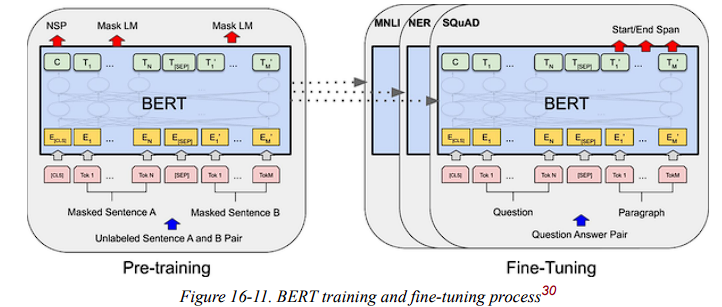

[Chain of thought prompting](https://homl.info/ctp)


### Vision Transformers:

1. a convolutional neural network first processes the image and outputs some
feature maps, then a decoder RNN equipped with an attention mechanism generates the caption, one
word at a time.

2. At each decoder time step (i.e., each word), the decoder uses the attention model to focus on just the
right part of the image. For example, in Figure 16-12, the model generated the caption “A woman is
throwing a frisbee in a park”, and you can see what part of the input image the decoder focused its
attention on when it was about to output the word “frisbee”: clearly, most of its attention was
focused on the frisbee.

### [Explainability](https://homl.info/explainclass)

3. Transformers became slightly more
visual in a [2020 paper](https://homl.info/detr) by Facebook researchers, which proposed a hybrid CNN–transformer
architecture for object detection.


4.  [a paper](https://homl.info/vit) that introduced a fully
transformer-based vision model, called a vision transformer (ViT). The idea is surprisingly simple:
just chop the image into little 16 × 16 squares, and treat the sequence of squares as if it were a
sequence of word representations. To be more precise, the squares are first flattened into 16 × 16 × 3
= 768-dimensional vectors—the 3 is for the RGB color channels—then these vectors go through a
linear layer that transforms them but retains their dimensionality. The resulting sequence of vectors
can then be treated just like a sequence of word embeddings: this means adding positional
embeddings, and passing the result to the transformer

>NOTE
An inductive bias is an implicit assumption made by the model, due to its architecture. For example, linear models
implicitly assume that the data is, well, linear. CNNs implicitly assume that patterns learned in one location will likely be
useful in other locations as well. RNNs implicitly assume that the inputs are ordered, and that recent tokens are more
important than older ones. The more inductive biases a model has, assuming they are correct, the less training data the
model will require. But if the implicit assumptions are wrong, then the model may perform poorly even if it is trained on
a large dataset.

5.  [a paper](https://homl.info/deit) that introduced dataefficient image transformers (DeiTs). Their model achieved competitive results on ImageNet without
requiring any additional data for training. The model’s architecture is virtually the same as the
original ViT, but the authors used a distillation technique to transfer knowledge from state-of-the-art
CNN models to their model.

>NOTE: The bottleneck is due to self-attention, where every token must attend to every other token: if
the input sequence has M tokens, then the attention layer must compute an M × M matrix, which can
be huge if M is very large.


6. [paper](https://homl.info/perceiver) that introduced the Perceiver
architecture. It is a multimodal transformer, meaning you can feed it text, images, audio, or virtually
any other modality.

* The Perceiver solves this problem by gradually improving a fairly short
latent representation of the inputs, composed of N tokens—typically just a few hundred. (The word
latent means hidden, or internal.) The model uses cross-attention layers only, feeding them the latent
representation as the queries, and the (possibly large) inputs as the values. This only requires
computing an M × N matrix, so the computational complexity is linear with regard to M, instead of
quadratic. After going through several cross-attention layers, if everything goes well, the latent
representation ends up capturing everything that matters in the inputs. The authors also suggested
sharing the weights between consecutive cross-attention layers: if you do that, then the Perceiver
effectively becomes an RNN. Indeed, the shared cross-attention layers can be seen as the same
memory cell at different time steps, and the latent representation corresponds to the cell’s context
vector. The same inputs are repeatedly fed to the memory cell at every time step. It looks like RNNs
are not dead after all!

7.  [DINO](https://homl.info/dino), an impressive vision transformer
trained entirely without labels, using self-supervision, and capable of high-accuracy semantic
segmentation. The model is duplicated during training, with one network acting as a teacher and the
other acting as a student. Gradient descent only affects the student, while the teacher’s weights are
just an exponential moving average of the student’s weights. The student is trained to match the
teacher’s predictions: since they’re almost the same model, this is called self-distillation.

* At each
training step, the input images are augmented in different ways for the teacher and the student, so
they don’t see the exact same image, but their predictions must match. This forces them to come up
with high-level representations.

* To prevent mode collapse, where both the student and the teacher
would always output the same thing, completely ignoring the inputs, DINO keeps track of a moving
average of the teacher’s outputs, and it tweaks the teacher’s predictions to ensure that they remain
centered on zero, on average. DINO also forces the teacher to have high confidence in its
predictions: this is called sharpening. Together, these techniques preserve diversity in the teacher’s
outputs.

8. In a  [2021 paper](https://homl.info/scalingvits), Google researchers showed how to scale ViTs up or down, depending on the
amount of data. They managed to create a huge 2 billion parameter model that reached over 90.4%
top-1 accuracy on ImageNet. Conversely, they also trained a scaled-down model that reached over
84.8% top-1 accuracy on ImageNet, using only 10,000 images: that’s just 10 images per class!

9. [a paper](https://homl.info/modelsoups) by Mitchell Wortsman et al. demonstrated that it’s possible to first train multiple
transformers, then average their weights to create a new and improved model.

10. [OpenAI’s 2021 CLIP paper](https://homl.info/clip) proposed a large transformer
model pretrained to match captions with images: this task allows it to learn excellent image
representations, and the model can then be used directly for tasks such as image classification using
simple text prompts such as “a photo of a cat”.

11. [ DALL·E](https://homl.info/dalle), capable
of generating amazing images based on text prompts.

12. The [DALL·E 2](https://homl.info/dalle2), which generates even higher
quality images using a diffusion model.

13. [Flamingo paper](https://homl.info/flamingo), which introduced a family of models
pretrained on a wide variety of tasks across multiple modalities, including text, images, and videos.

14.  [GATO](https://homl.info/gato), a multimodal model
that can be used as a policy for a reinforcement learning agent.


>NOTE
These astounding advances have led some researchers to claim that human-level AI is near, that “scale is all you need”,
and that some of these models may be “slightly conscious”. Others point out that despite the amazing progress, these
models still lack the reliability and adaptability of human intelligence, our ability to reason symbolically, to generalize
based on a single example, and more.



### Hugging Face’s Transformers Library

The simplest way to use the Transformers library is to use the transformers.pipeline() function:
you just specify which task you want, such as sentiment analysis, and it downloads a default
pretrained model, ready to be used—it really couldn’t be any simpler:

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis") #many other tasks are available
result = classifier("The actors were very convincing")

In [ ]:
result

In [ ]:
classifier(["I am from India.","I am from Iraq"])

### BIAS AND FAIRNESS

>Understanding bias in AI and mitigating its negative effects is still an area of active research, but
one thing is certain: you should pause and think before you rush to deploy a model to
production. Ask yourself how the model could do harm, even indirectly.

you could use a DistilBERT model fine-tuned on the Multi-Genre Natural Language
Inference (MultiNLI) task, which classifies two sentences into three classes: contradiction, neutral,
or entailment. Here is how:

In [ ]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")

1. The pipeline API is very simple and convenient, but sometimes you will need more control. For such
cases, the Transformers library provides many classes, including all sorts of tokenizers, models,
configurations, callbacks, and much more.

 For example, let’s load the same DistilBERT model,
along with its corresponding tokenizer, using the TFAutoModelForSequenceClassification and
AutoTokenizer classes:


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)


Next, let’s tokenize a couple of pairs of sentences. In this code, we activate padding and specify that
we want TensorFlow tensors instead of Python lists:


In [ ]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                       padding=True,
                       return_tensors="tf")



>TIP
Instead of passing "Sentence 1 [SEP] Sentence 2" to the tokenizer, you can equivalently pass it a tuple: ("Sentence
1", "Sentence 2").

The output is a dictionary-like instance of the BatchEncoding class, which contains the sequences of
token IDs, as well as a mask containing 0s for the padding tokens:


In [ ]:
token_ids

If you set return_token_type_ids=True when calling the tokenizer, you will also get an extra
tensor that indicates which sentence each token belongs to. This is needed by some models, but not
DistilBERT.


Next, we can directly pass this BatchEncoding object to the model; it returns a
TFSequenceClassifierOutput object containing its predicted class logits:

In [ ]:
outputs = model(token_ids)
outputs

Lastly, we can apply the softmax activation function to convert these logits to class probabilities, and
use the argmax() function to predict the class with the highest probability for each input sentence
pair:

In [ ]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

In [ ]:
Y_pred = tf.argmax(Y_probas,axis=1)
Y_pred # 0 = contradiction, 1 = entailment, 2 = neutral

In this example, the model correctly classifies the first sentence pair as neutral (the fact that I like
soccer does not imply that everyone else does) and the second pair as an entailment (Joe must indeed
be quite old).

If you wish to fine-tune this model on your own dataset, you can train the model as usual with Keras
since it’s just a regular Keras model with a few extra methods. However, because the model outputs
logits instead of probabilities, you must use the
tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) loss instead of the
usual "sparse_categorical_crossentropy" loss. Moreover, the model does not support
BatchEncoding inputs during training, so you must use its data attribute to get a regular dictionary
instead:

In [ ]:
sentences = [("Sky is blue","Sky is red"),("I love her","She loves me")]
X_train = tokenizer(sentences,padding=True,
                    return_tensors="tf").data
y_train = tf.constant([0,2]) # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,
              optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train,y_train,epochs=2)

Hugging Face has also built a Datasets library that you can use to easily download a standard dataset
(such as IMDb) or a custom one, and use it to fine-tune your model. It’s similar to TensorFlow
Datasets, but it also provides tools to perform common preprocessing tasks on the fly, such as
masking. The list of datasets is available at https://huggingface.co/datasets.

This should get you started with Hugging Face’s ecosystem. To learn more, you can head over to
https://huggingface.co/docs for the documentation, which includes many tutorial notebooks, videos,
the full API, and more. I also recommend you check out the O’Reilly book Natural Language
Processing with Transformers: Building Language Applications with Hugging Face 
